In [77]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import matplotlib.pyplot as plt
import numpy as np
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

Let's load the Iris dataset again.

In [46]:
from sklearn import datasets

iris = datasets.load_iris()

X = iris.data
y = iris.target

Let's plot the data to have a better look at it. Below we plot the flowers in the Iris dataset according to their sepal length and width, and we label them according to color.

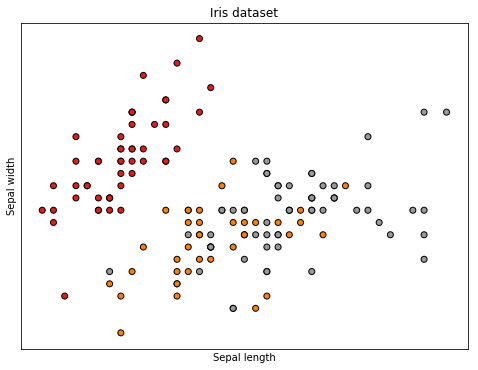

In [47]:
# plotting code taken from http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.title('Iris dataset')

In the last lesson, we manually trained a neural network to classify the Iris dataset. This time, let's use the Keras library instead. First we need to pre-process the data

In [48]:
# how many samples in the dataset and how many classes?
num_samples = len(y)
num_classes = 1+int(np.amax(y, axis=0))

# shuffle the dataset
shuffle_order = np.random.permutation(num_samples)
X = X[shuffle_order, :]
y = y[shuffle_order]

# normalize X to between 0 and 1 and make sure it's float32
X = X / np.amax(X, axis=0)
X = X.astype('float32')

print("shape of X", X.shape)
print("first 3 rows of X\n", X[0:3, :])

shape of X (150, 4)
first 3 rows of X
 [[0.84810126 0.70454544 0.8115942  0.96      ]
 [0.62025315 0.70454544 0.2173913  0.04      ]
 [0.62025315 0.5681818  0.65217394 0.68      ]]


We need to split the data into a training set and a test set. Let's take the first 30% of the dataset to use as a test set.

TODO: why?

In [49]:
test_split = 0.3

n_test = int(test_split * num_samples)

x_train, x_test = X[n_test:, :], X[:n_test, :] 
y_train, y_test = y[n_test:], y[:n_test] 

print('%d training samples, %d test samples' % (x_train.shape[0], x_test.shape[0]))

105 training samples, 45 test samples


Convert the labels into one-hot vectors. So if there are 3 classes, label 0 = [1, 0, 0], label 1 = [0, 1, 0], etc.

In [50]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Training data shape: X", x_train.shape, " y", y_train.shape)
print("Test data shape: X", x_test.shape, " y", y_test.shape)

Training data shape: X (105, 4)  y (105, 3)
Test data shape: X (45, 4)  y (45, 3)


In Keras, to instantiate a neural network model, we use the `Sequential` class. Sequential simply means a model with a sequence of layers which propagate in one direction, from input to output. 

In [63]:
model = Sequential()

We now have an empty neural network called `model`. Now let's add our first layer, which will be our input layer. We will do this using Keras's `Dense` class which will instantiate our input layer.

The reason why it is called "Dense" is that the layer is "fully-connected," which means that all of it's neurons are connected to all the neurons in the previous layer, with no empty connections. This may seem confusing at first because we have not yet seen neural network layers which are not fully-connected; we will see this in the next chapter when we introduce convolutional networks. 

To create a Dense layer, we have three arguments that need to be specified: the number of neurons, the activation function, and the 



In [64]:
model.add(Dense(20, activation='sigmoid', input_dim=4))


TODO: make a graphic of the net architecture

We can also get a readout of the current state of the network using `model.summary`:

In [68]:
model.summary()


Let's add another layer of 20 neurons, also with sigmoid activation, and look at the summary of the graph now.

In [69]:
model.add(Dense(20, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 583
Trainable params: 583
Non-trainable params: 0
_________________________________________________________________


Finally, we will add the output layer, which will be a fully-connected (Dense) layer whose size is the number of classes, which in our case is 3, for the three different flower types.

Notice that this time, instead of having the activation be a sigmoid as before, now we use the softmax activation, which is the most typical and recommended activation function for the output layer in a multi-class classification such as this.

We add it, and look at the final summary.

In [70]:
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                100       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 12        
Total params: 595
Trainable params: 595
Non-trainable params: 0
_________________________________________________________________


Now we are finished specifying the architecture of the model. Now we need to specify our loss function and optimizer, and then compile the model. Let's discuss each of these things.

We introduces loss functions in the last session, and we used the simple mean-squared error (MSE) loss function to evaluate the quality of our network. While MSE works nicely for regression, and can work for classification as well, it is generally not preferred for classification, because class variables are not naturally continuous and therefore, the MSE error, being a continuous value is not quite the right loss function. Instead, what scientists generally prefer for multi-class classification is categorical cross-entropy loss


TODO: define cross-entropy
https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html


Additionally, we must select an optimizer. The optimizer is the specific variant of gradient descent which will be used in training. These ...

TODO: optimizers

Finally, the model is compiled. Compiling means that Keras (actually Tensorflow internally) is allocating memory for a "computational graph" whose architecture is that which is specified by your model definition. This is done for optimization purposes, and a full understanding of how that's done is not necessary for this course and is beyond its scope.

In compiling, we can also pass a set of metrics to keep track of during training. Since we are performing classification, the most useful one for now is just accuracy.

In [73]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])

We are finally ready to train. In the next cell, we run the `fit` command which will begin the process of training. There are several important arguments to fit. The first is the training data and labels (`x_train` and `y_train`), as well as the validation set (`x_test` and `y_test`). 

Additionally, we must specify the `batch_size` which refers to the number of training samples to calculate the gradient over, as well as the number of `epochs`, which refers to the number of times we cycle through the training set. In general, more epochs are usually better, although in practice, the accuracy of the network may stop improving early, which makes it unnecessary to train too many epochs.

TODO: validation set why?

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=20,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

As you can see above, we see ___

We can evaluate the training set one last time at the end.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

We can also predict the value of a single unknown example or a set of them in th following way:

Let's now train another neural network, but use a more complicated dataset; that of MNIST. MNIST is a dataset of handwritten digits

In [91]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

Let's see what the data is packaged like:

In [92]:
print('%d train samples, %d test samples'%(x_train.shape[0], x_test.shape[0]))
print("training data shape: ", x_train.shape, y_train.shape)
print("test data shape: ", x_test.shape, y_test.shape)

60000 train samples, 10000 test samples
training data shape:  (60000, 28, 28) (60000,)
test data shape:  (10000, 28, 28) (10000,)


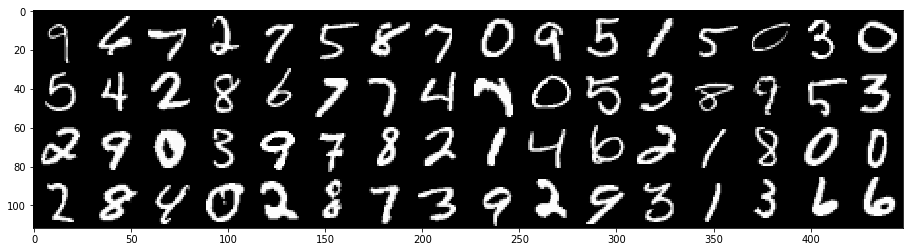

In [93]:
samples = np.concatenate([np.concatenate([x_train[i] for i in [int(random.random() * len(x_train)) for i in range(16)]], axis=1) for i in range(4)], axis=0)
plt.figure(figsize=(16,4))
plt.imshow(samples, cmap='gray')

In [94]:
z = x_test
print(z.dtype)
z = z/ 255.0
print(z.dtype)

preprocessing

uint8
float64


NameError: name 'preprocessing' is not defined

In [95]:

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [96]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Now let's make a 

TODO: relu activation

In [102]:
model = Sequential()
model.add(Dense(256, activation='sigmoid', input_dim=784))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

In [103]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
Total params: 227,670
Trainable params: 227,670
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])

In [105]:
model.fit(x_train, y_train,
          batch_size=100,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.5200 - acc: 0.8676 - val_loss: 0.2435 - val_acc: 0.9261
Epoch 2/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.2151 - acc: 0.9357 - val_loss: 0.1834 - val_acc: 0.9416
Epoch 3/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.1599 - acc: 0.9520 - val_loss: 0.1383 - val_acc: 0.9577
Epoch 4/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.1243 - acc: 0.9628 - val_loss: 0.1171 - val_acc: 0.9644
Epoch 5/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.1005 - acc: 0.9696 - val_loss: 0.1019 - val_acc: 0.9683
Epoch 6/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.0825 - acc: 0.9754 - val_loss: 0.0946 - val_acc: 0.9701
Epoch 7/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.0695 - acc: 0.9790 - val_loss: 0.0887 - val_acc

Evaluate

In [106]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07155236485830974
Test accuracy: 0.9807


We can do better!

bigger network + use RELU
also dropout? or maybe in next chapter

In [107]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=784))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [108]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=100,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.2051 - acc: 0.9365 - val_loss: 0.0932 - val_acc: 0.9717
Epoch 2/20
60000/60000 [==============================] - 4s 61us/step - loss: 0.0807 - acc: 0.9745 - val_loss: 0.0782 - val_acc: 0.9754
Epoch 3/20
60000/60000 [==============================] - 4s 62us/step - loss: 0.0547 - acc: 0.9837 - val_loss: 0.0859 - val_acc: 0.9745
Epoch 4/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.0399 - acc: 0.9878 - val_loss: 0.0825 - val_acc: 0.9793
Epoch 5/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0303 - acc: 0.9910 - val_loss: 0.0960 - val_acc: 0.9774
Epoch 6/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.0232 - acc: 0.9930 - val_loss: 0.0980 - val_acc: 0.9793
Epoch 7/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.0209 - acc: 0.9938 - val_loss: 0.0840 - val_acc


Current state of the art is:

Now let's try CIFAR. 